## Weather Prediction:  A comparision of traditional and modern methods

In this study, we are going to use Python and Machine Learning to build models to predict weather temperatures based off data from WorldWeatherOnline. There are three "phases" to this study:

1. Data collection and processing (i.e. like doing an experiment!)
2. Using Linear Regression models (i.e. a traditional fitting approach)
3. Using Neural Network models (i.e. a machine-learning approach)

The data used will be collected from the WorldWeatherOnline API web services. We will interact with the API to pull in weather data over a given time period, for a given location.

Once collected, the data will need to be processed and aggregated into a format that is suitable for data analysis, and then cleaned.

In [1]:
# import the usual libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats

# We are going to need several additional libraries.  We import them here, but
# I will discuss their purpose and give further details as they are used.

In [2]:
import os
os.chdir("/home/brash/Phys421/WWO")
df = pd.read_csv('malta.csv')

In [3]:
df.head()

,date_time,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,moonrise,moonset,sunrise,...,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,location
0,2019-01-01 00:00:00,15,13,0.0,7.0,4,26,03:43 AM,02:52 PM,08:12 AM,...,59,55,62,0.5,1021,13,10,342,46,malta
1,2019-01-01 03:00:00,15,13,0.0,7.0,4,26,03:43 AM,02:52 PM,08:12 AM,...,54,78,59,0.4,1019,14,9,343,45,malta
2,2019-01-01 06:00:00,15,13,0.0,7.0,4,26,03:43 AM,02:52 PM,08:12 AM,...,45,81,56,0.3,1018,14,10,355,39,malta
3,2019-01-01 09:00:00,15,13,0.0,7.0,4,26,03:43 AM,02:52 PM,08:12 AM,...,36,28,56,0.1,1019,14,10,127,31,malta
4,2019-01-01 12:00:00,15,13,0.0,7.0,4,26,03:43 AM,02:52 PM,08:12 AM,...,33,42,57,0.0,1020,14,10,6,28,malta


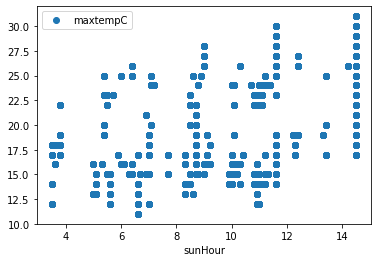

In [4]:
df.plot('sunHour','maxtempC',style='o')

In [5]:
df.describe()

,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
count,2920.000000,2920.000000,2920.0,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000
mean,20.665753,18.191781,0.0,10.386301,5.342466,45.084932,14.519863,20.109589,20.671918,19.297260,31.344521,27.960274,71.764041,0.257226,1015.383904,19.646575,10.270548,222.819863,21.825000
std,5.250615,5.282191,0.0,2.850641,1.271817,31.265919,5.184993,6.635442,6.059308,5.716974,17.935454,31.020815,7.626257,1.150975,5.335238,5.242697,2.191599,91.593935,12.714478
min,11.000000,4.000000,0.0,3.500000,3.000000,0.000000,0.000000,4.000000,7.000000,4.000000,1.000000,0.000000,48.000000,0.000000,987.000000,-2.000000,2.000000,4.000000,0.000000
25%,16.000000,14.000000,0.0,8.700000,4.000000,17.000000,11.000000,15.000000,15.000000,15.000000,18.000000,2.000000,67.000000,0.000000,1012.000000,15.000000,10.000000,147.000000,12.000000
50%,19.000000,17.000000,0.0,11.300000,5.000000,44.000000,14.000000,18.000000,19.000000,18.000000,28.000000,12.000000,72.000000,0.000000,1015.000000,18.000000,10.000000,253.500000,20.000000
75%,26.000000,24.000000,0.0,11.600000,7.000000,72.000000,19.000000,27.000000,27.000000,25.000000,41.000000,52.000000,77.000000,0.000000,1019.000000,25.000000,10.000000,299.000000,29.000000
max,31.000000,28.000000,0.0,14.500000,8.000000,100.000000,24.000000,34.000000,34.000000,31.000000,115.000000,100.000000,91.000000,27.900000,1030.000000,31.000000,20.000000,360.000000,85.000000


In [6]:
# Create new feature columns ... the idea is that we are going to
# try to predict the temperature for tomorrow by looking at what
# happened today, and for the past three days.

# For each feature that we think might be an important factor in
# determining out temperature forecast, we will add a column to the
# dataframe for this variable for each of the previous three days.

def derive_nth_day_feature(df, feature, N):
    rows = df.shape[0]
    nth_prior_measurements = [None]*N + [df[feature][i-N] for i in range(N, rows)]
    col_name = "{}_{}".format(feature, N)
    df[col_name] = nth_prior_measurements

In [7]:
# These are the features/variables that we think a priori might be
# important in our forecasting model

features = ["date_time", "tempC", "DewPointC","pressure","humidity",
            "maxtempC", "mintempC", "sunHour", "windspeedKmph",
            "winddirDegree","precipMM"]


In [8]:
# Now, for each of these features, add three new columns to the
# dataframe which correspond to yesterday, the day before yesterday,
# and the day before that.  The column names will be the same as
# the name as the original feature, but with _1, _2, or _3 added on.

for feature in features:
    if feature != 'date_time':
        for N in range(1, 4):
            derive_nth_day_feature(df, feature, N)

In [9]:
# We see now that we have accomplished our task ... a lot of new
# columns have been added!

df.columns

Index(['date_time', 'maxtempC', 'mintempC', 'totalSnow_cm', 'sunHour',
       'uvIndex', 'moon_illumination', 'moonrise', 'moonset', 'sunrise',
       'sunset', 'DewPointC', 'FeelsLikeC', 'HeatIndexC', 'WindChillC',
       'WindGustKmph', 'cloudcover', 'humidity', 'precipMM', 'pressure',
       'tempC', 'visibility', 'winddirDegree', 'windspeedKmph', 'location',
       'tempC_1', 'tempC_2', 'tempC_3', 'DewPointC_1', 'DewPointC_2',
       'DewPointC_3', 'pressure_1', 'pressure_2', 'pressure_3', 'humidity_1',
       'humidity_2', 'humidity_3', 'maxtempC_1', 'maxtempC_2', 'maxtempC_3',
       'mintempC_1', 'mintempC_2', 'mintempC_3', 'sunHour_1', 'sunHour_2',
       'sunHour_3', 'windspeedKmph_1', 'windspeedKmph_2', 'windspeedKmph_3',
       'winddirDegree_1', 'winddirDegree_2', 'winddirDegree_3', 'precipMM_1',
       'precipMM_2', 'precipMM_3'],
      dtype='object')

In [10]:
# We now want to clean up the dataframe, and get rid of columns that
# we are not interested in.  This is not so important in this example,
# but if we are dealing with large dataframes with thousands of columns
# of data, it can really speed things up by condensing things.

# make list of original features we are not interested in
to_remove = [feature 
             for feature in features 
             if feature not in ['date_time','maxtempC', 'mintempC', 'tempC']]
for col in ['DewPointC','pressure','humidity','sunHour',
                'windspeedKmph','winddirDegree','precipMM',
                 'totalSnow_cm','uvIndex','moon_illumination',
                  'moonrise','moonset','sunrise','sunset','FeelsLikeC',
                 'HeatIndexC','WindChillC','WindGustKmph','cloudcover',
                 'visibility','location']:
    to_remove.append(col)

print(to_remove)

# make a list of columns to keep
to_keep = [col for col in df.columns if col not in to_remove]

print(to_keep)

# select only the columns in to_keep and assign to df
df = df[to_keep]
df.columns

['DewPointC', 'pressure', 'humidity', 'sunHour', 'windspeedKmph', 'winddirDegree', 'precipMM', 'DewPointC', 'pressure', 'humidity', 'sunHour', 'windspeedKmph', 'winddirDegree', 'precipMM', 'totalSnow_cm', 'uvIndex', 'moon_illumination', 'moonrise', 'moonset', 'sunrise', 'sunset', 'FeelsLikeC', 'HeatIndexC', 'WindChillC', 'WindGustKmph', 'cloudcover', 'visibility', 'location']
['date_time', 'maxtempC', 'mintempC', 'tempC', 'tempC_1', 'tempC_2', 'tempC_3', 'DewPointC_1', 'DewPointC_2', 'DewPointC_3', 'pressure_1', 'pressure_2', 'pressure_3', 'humidity_1', 'humidity_2', 'humidity_3', 'maxtempC_1', 'maxtempC_2', 'maxtempC_3', 'mintempC_1', 'mintempC_2', 'mintempC_3', 'sunHour_1', 'sunHour_2', 'sunHour_3', 'windspeedKmph_1', 'windspeedKmph_2', 'windspeedKmph_3', 'winddirDegree_1', 'winddirDegree_2', 'winddirDegree_3', 'precipMM_1', 'precipMM_2', 'precipMM_3']


Index(['date_time', 'maxtempC', 'mintempC', 'tempC', 'tempC_1', 'tempC_2',
       'tempC_3', 'DewPointC_1', 'DewPointC_2', 'DewPointC_3', 'pressure_1',
       'pressure_2', 'pressure_3', 'humidity_1', 'humidity_2', 'humidity_3',
       'maxtempC_1', 'maxtempC_2', 'maxtempC_3', 'mintempC_1', 'mintempC_2',
       'mintempC_3', 'sunHour_1', 'sunHour_2', 'sunHour_3', 'windspeedKmph_1',
       'windspeedKmph_2', 'windspeedKmph_3', 'winddirDegree_1',
       'winddirDegree_2', 'winddirDegree_3', 'precipMM_1', 'precipMM_2',
       'precipMM_3'],
      dtype='object')

In [11]:
# If we look at the dataframe now, we see that we have just the
# columns that we are interested in.  All of the columns are either
# integers or floats, and so we don't need to do anything else.

# However, we also notice that for some columns, we are missing a few
# data points.  The reason for this is simple:  If we are looking back
# several days, the first entry in the column for a particular variable
# is not going to have any data associated with it for previous days,
# the second entry in a column will only have data for the previous day,
# etc.  We can handle this by droping rows that do not have complete data!

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2920 entries, 0 to 2919
Data columns (total 34 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date_time        2920 non-null   object 
 1   maxtempC         2920 non-null   int64  
 2   mintempC         2920 non-null   int64  
 3   tempC            2920 non-null   int64  
 4   tempC_1          2919 non-null   float64
 5   tempC_2          2918 non-null   float64
 6   tempC_3          2917 non-null   float64
 7   DewPointC_1      2919 non-null   float64
 8   DewPointC_2      2918 non-null   float64
 9   DewPointC_3      2917 non-null   float64
 10  pressure_1       2919 non-null   float64
 11  pressure_2       2918 non-null   float64
 12  pressure_3       2917 non-null   float64
 13  humidity_1       2919 non-null   float64
 14  humidity_2       2918 non-null   float64
 15  humidity_3       2917 non-null   float64
 16  maxtempC_1       2919 non-null   float64
 17  maxtempC_2    

In [12]:
# the last task is to convert the date_time column from an object into a floating point number
# there are a number of ways that we could do this

df['date'] = pd.to_datetime(df['date_time'])    
df['date_delta'] = (df['date'] - df['date'].min())  / np.timedelta64(1,'D')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2920 entries, 0 to 2919
Data columns (total 36 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date_time        2920 non-null   object        
 1   maxtempC         2920 non-null   int64         
 2   mintempC         2920 non-null   int64         
 3   tempC            2920 non-null   int64         
 4   tempC_1          2919 non-null   float64       
 5   tempC_2          2918 non-null   float64       
 6   tempC_3          2917 non-null   float64       
 7   DewPointC_1      2919 non-null   float64       
 8   DewPointC_2      2918 non-null   float64       
 9   DewPointC_3      2917 non-null   float64       
 10  pressure_1       2919 non-null   float64       
 11  pressure_2       2918 non-null   float64       
 12  pressure_3       2917 non-null   float64       
 13  humidity_1       2919 non-null   float64       
 14  humidity_2       2918 non-null   float64

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


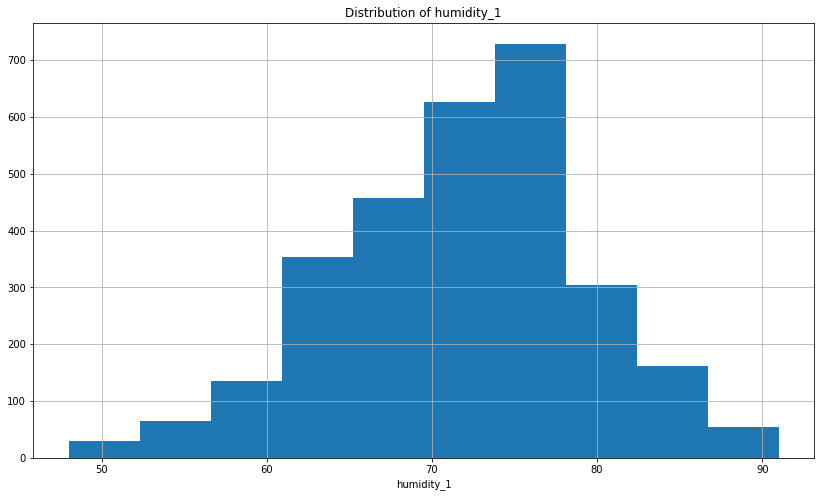

In [13]:
# Let us now look at a few of the columns of data
#
# We see that humidity, for example, is NOT a normal distribution!  We
# should remember that, going forward, as it may end up causing issues.

%matplotlib inline
plt.rcParams['figure.figsize'] = [14, 8]
df.humidity_1.hist()
plt.title('Distribution of humidity_1')
plt.xlabel('humidity_1')
plt.show()

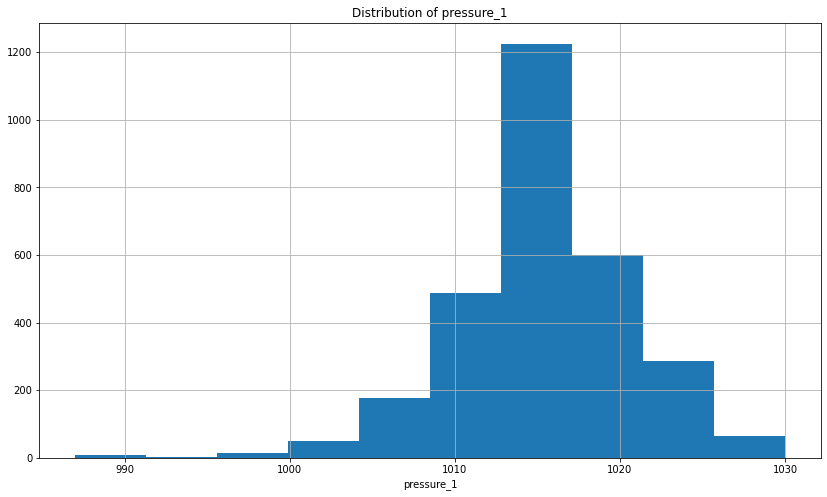

In [14]:
# The pressure, on the other hand, looks like a nice Gaussian distribution.
# We really should look at EVERY column in this manner, and try to determine
# if the distribution is normal, and if there are any bad data points (outliers).

df.pressure_1.hist()
plt.title('Distribution of pressure_1')
plt.xlabel('pressure_1')
plt.show()

In [15]:
df.describe()

,maxtempC,mintempC,tempC,tempC_1,tempC_2,tempC_3,DewPointC_1,DewPointC_2,DewPointC_3,pressure_1,...,windspeedKmph_1,windspeedKmph_2,windspeedKmph_3,winddirDegree_1,winddirDegree_2,winddirDegree_3,precipMM_1,precipMM_2,precipMM_3,date_delta
count,2920.000000,2920.000000,2920.000000,2919.000000,2918.000000,2917.000000,2919.000000,2918.000000,2917.000000,2919.000000,...,2919.000000,2918.000000,2917.000000,2919.000000,2918.000000,2917.000000,2919.000000,2918.000000,2917.000000,2920.000000
mean,20.665753,18.191781,19.646575,19.649880,19.652159,19.654097,14.522782,14.525360,14.527597,1015.379582,...,21.822199,21.817341,21.811450,222.881466,222.941741,222.997943,0.257246,0.257231,0.257182,182.437500
std,5.250615,5.282191,5.242697,5.240553,5.240004,5.239857,5.183482,5.182498,5.181977,5.331037,...,12.715756,12.715225,12.713422,91.549106,91.506850,91.472154,1.151172,1.151369,1.151563,105.384465
min,11.000000,4.000000,-2.000000,-2.000000,-2.000000,-2.000000,0.000000,0.000000,0.000000,987.000000,...,0.000000,0.000000,0.000000,4.000000,4.000000,4.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,14.000000,15.000000,15.000000,15.000000,15.000000,11.000000,11.000000,11.000000,1012.000000,...,12.000000,12.000000,12.000000,147.000000,147.000000,147.000000,0.000000,0.000000,0.000000,91.218750
50%,19.000000,17.000000,18.000000,18.000000,18.000000,18.000000,14.000000,14.000000,14.000000,1015.000000,...,20.000000,19.500000,19.000000,254.000000,254.000000,254.000000,0.000000,0.000000,0.000000,182.437500
75%,26.000000,24.000000,25.000000,25.000000,25.000000,25.000000,19.000000,19.000000,19.000000,1019.000000,...,29.000000,29.000000,29.000000,299.000000,299.000000,299.000000,0.000000,0.000000,0.000000,273.656250
max,31.000000,28.000000,31.000000,31.000000,31.000000,31.000000,24.000000,24.000000,24.000000,1030.000000,...,85.000000,85.000000,85.000000,360.000000,360.000000,360.000000,27.900000,27.900000,27.900000,364.875000


In [16]:
# Now, let's get rid of the rows that do not have complete data!

df = df.dropna()

In [17]:
df.describe()

,maxtempC,mintempC,tempC,tempC_1,tempC_2,tempC_3,DewPointC_1,DewPointC_2,DewPointC_3,pressure_1,...,windspeedKmph_1,windspeedKmph_2,windspeedKmph_3,winddirDegree_1,winddirDegree_2,winddirDegree_3,precipMM_1,precipMM_2,precipMM_3,date_delta
count,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,...,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000
mean,20.671580,18.197120,19.652725,19.654097,19.654439,19.654097,14.528625,14.528282,14.527597,1015.376414,...,21.805965,21.809050,21.811450,222.799451,222.900926,222.997943,0.257113,0.257148,0.257182,182.625000
std,5.250167,5.282281,5.241860,5.239857,5.239454,5.239857,5.180450,5.180981,5.181977,5.331426,...,12.704975,12.709515,12.713422,91.526862,91.495970,91.472154,1.151555,1.151558,1.151563,105.276212
min,11.000000,4.000000,-2.000000,-2.000000,-2.000000,-2.000000,0.000000,0.000000,0.000000,987.000000,...,0.000000,0.000000,0.000000,4.000000,4.000000,4.000000,0.000000,0.000000,0.000000,0.375000
25%,16.000000,14.000000,15.000000,15.000000,15.000000,15.000000,11.000000,11.000000,11.000000,1012.000000,...,12.000000,12.000000,12.000000,147.000000,147.000000,147.000000,0.000000,0.000000,0.000000,91.500000
50%,19.000000,17.000000,18.000000,18.000000,18.000000,18.000000,14.000000,14.000000,14.000000,1015.000000,...,19.000000,19.000000,19.000000,253.000000,254.000000,254.000000,0.000000,0.000000,0.000000,182.625000
75%,26.000000,24.000000,25.000000,25.000000,25.000000,25.000000,19.000000,19.000000,19.000000,1019.000000,...,29.000000,29.000000,29.000000,299.000000,299.000000,299.000000,0.000000,0.000000,0.000000,273.750000
max,31.000000,28.000000,31.000000,31.000000,31.000000,31.000000,24.000000,24.000000,24.000000,1030.000000,...,85.000000,85.000000,85.000000,360.000000,360.000000,360.000000,27.900000,27.900000,27.900000,364.875000


## We are now ready to do a linear regression fit to the data!!

In [18]:
# our first task is to determine what the important variables/features are!
#
# The corr() method of the dataframe object will return the Pearson correlation
# coefficient, r, which measures the amount of correlation between two variables.
#
# Values close to 1 indicate a strong positive correlation; values close to -1
# indicate a strong negative correlation, and values close to zero indicate little
# correlation.  We want to look at the correlation between all of the variables in
# our dataframe with the daily mean temperature (tempC).  We will also sort these 
# values from smallest to largest.
#
# Perhaps not surprisingly, the strongest positive correlations come from looking at
# the temperature in the previous days.  The strongest negative correlations are
# associated with pressure and temperature.  That is, if the pressure is low, 
# the temperatures tend to be a little higher, and vice versa, and if the humidity is low
# the temperatures tend to be a little higher, and vice versa.

df.corr()[['tempC']].sort_values('tempC')

,tempC
windspeedKmph_3,-0.434147
windspeedKmph_2,-0.431313
windspeedKmph_1,-0.425927
pressure_1,-0.156134
pressure_3,-0.153740
pressure_2,-0.152783
precipMM_1,-0.147703
precipMM_2,-0.134327
precipMM_3,-0.124894
winddirDegree_2,-0.048276


In [19]:
# for our model, we will only include variables where the abs(r) > 0.5 - that is, either
# a strong positive or strong negative correlation.

predictors = ['tempC_1',  'DewPointC_1',  'maxtempC_2', 
              'maxtempC_1',   'mintempC_1',   'maxtempC_3',
              'mintempC', 'maxtempC', 'mintempC_2',
              'tempC_2',  'DewPointC_2',  'mintempC_3',
              'tempC_3',  'DewPointC_3',  'pressure_1',
              'pressure_2',   'pressure_3', 'humidity_1']
df2 = df[['date_delta']+['tempC'] + predictors]

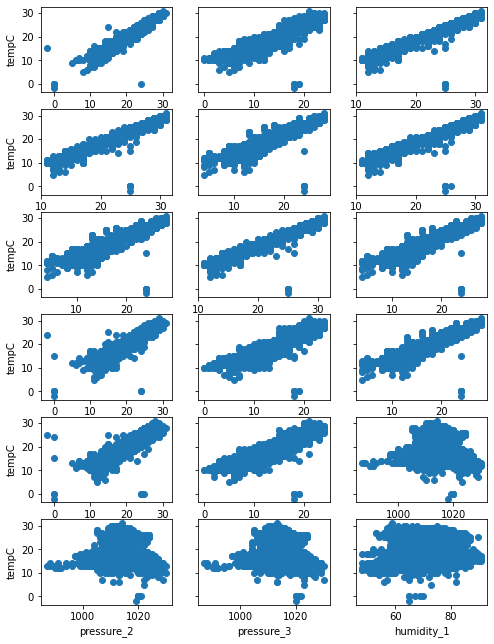

In [20]:
plt.rcParams['figure.figsize'] = [8, 11]
fig, axes = plt.subplots(nrows=6, ncols=3, sharey=True)
arr = np.array(predictors).reshape(6, 3)

for row, col_arr in enumerate(arr):
    for col, feature in enumerate(col_arr):
        axes[row, col].scatter(df2[feature], df2['tempC'])
        if col == 0:
            axes[row, col].set(xlabel=feature, ylabel='tempC')
        else:
            axes[row, col].set(xlabel=feature)
plt.show()

In [21]:
# import the relevant module
import statsmodels.api as sm

# separate our my predictor variables (X) from my outcome variable y
X = df2[predictors+['date_delta']]
y = df2['tempC']

# Add a constant to the predictor variable set to represent the Bo intercept
X = sm.add_constant(X)

In [22]:
# (1) select a significance value
alpha = 0.05

# (2) Fit the model
model = sm.OLS(y, X).fit()

# (3) evaluate the coefficients' p-values
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  tempC   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     4465.
Date:                Sun, 27 Sep 2020   Prob (F-statistic):               0.00
Time:                        12:47:10   Log-Likelihood:                -3996.6
No. Observations:                2917   AIC:                             8033.
Df Residuals:                    2897   BIC:                             8153.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.5558      3.637      0.428      0.669      -5.575       8.687
tempC_1         0.9194      0.020     47.000      0.000       0.881       0.958
DewPointC_1     0.1374      0.034      4.054      0.000       0.071       0.204
maxtempC_2      0.0722      0.064      1.122      0.262      -0.054       0.198
maxtempC_1      0.0581      0.064      0.904      0.366      -0.068       0.184
mintempC_1     -0.1386      0.031     -4.519      0.000      -0.199      -0.078
maxtempC_3     -0.0590      0.047     -1.249      0.212      -0.152       0.034
mintempC        0.2181      0.022      9.919      0.000       0.175       0.261
maxtempC        0.1464      0.046      3.149      0.002       0.055       0.238
mintempC_2     -0.0836      0.030     -2.747      0.006      -0.143      -0.024
tempC_2        -0.2272      0.025     -8.935      0.000      -0.277      -0.177
DewPointC_2    -0.1244      0.037     -3.325      0.001      -0.198      -0.051
mintempC_3      0.0904      0.022      4.112      0.000       0.047       0.134
tempC_3        -0.0043      0.019     -0.230      0.818      -0.041       0.032
DewPointC_3    -0.0152      0.026     -0.593      0.554      -0.065       0.035
pressure_1      0.1163      0.021      5.451      0.000       0.074       0.158
pressure_2     -0.0075      0.035     -0.216      0.829      -0.075       0.060
pressure_3     -0.1107      0.022     -5.138      0.000      -0.153      -0.068
humidity_1      0.0071      0.006      1.120      0.263      -0.005       0.019
date_delta      0.0002      0.000      1.138      0.255      -0.000       0.001
==============================================================================
Omnibus:                     3688.034   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2504209.415
Skew:                          -6.238   Prob(JB):                         0.00
Kurtosis:                     145.997   Cond. No.                     3.64e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.64e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [23]:
# Looking at the p-values of this fit, we see that MANY of them are well above the
# threshold alpha=0.05 that we require for significance.  Thus, we should remove these!
#
# If we do not, we are guilty of OVERFITTING the data!!!!!!

X = X.drop('pressure_3', axis=1)
X = X.drop('pressure_2', axis=1)
X = X.drop('pressure_1', axis=1)
X = X.drop('mintempC_3', axis=1)
X = X.drop('mintempC_2', axis=1)
X = X.drop('mintempC_1', axis=1)
X = X.drop('maxtempC_1', axis=1)
X = X.drop('maxtempC_2', axis=1)
X = X.drop('tempC_3', axis=1)
X = X.drop('mintempC', axis=1)
X = X.drop('maxtempC', axis=1)

In [24]:
model = sm.OLS(y, X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  tempC   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     9529.
Date:                Sun, 27 Sep 2020   Prob (F-statistic):               0.00
Time:                        12:47:10   Log-Likelihood:                -4152.6
No. Observations:                2917   AIC:                             8323.
Df Residuals:                    2908   BIC:                             8377.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.3307      0.550      4.236      0.000       1.252       3.410
tempC_1         0.8908      0.019     46.940      0.000       0.854       0.928
DewPointC_1     0.2491      0.033      7.469      0.000       0.184       0.315
maxtempC_3      0.1952      0.023      8.581      0.000       0.151       0.240
tempC_2        -0.2245      0.018    -12.223      0.000      -0.261      -0.188
DewPointC_2    -0.1156      0.039     -2.952      0.003      -0.192      -0.039
DewPointC_3     0.0015      0.026      0.056      0.956      -0.050       0.053
humidity_1     -0.0244      0.006     -3.981      0.000      -0.036      -0.012
date_delta     -0.0001      0.000     -0.619      0.536      -0.001       0.000
==============================================================================
Omnibus:                     3558.669   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1881169.944
Skew:                          -5.902   Prob(JB):                         0.00
Kurtosis:                     126.848   Cond. No.                     6.62e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.62e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [25]:
beta0 = model.params[0]
beta1 = model.params[1]
beta2 = model.params[2]
beta3 = model.params[3]
beta4 = model.params[4]
beta5 = model.params[5]
beta6 = model.params[6]
beta7 = model.params[7]

yfit = beta0 + beta1*df2['tempC_1'] + beta2*df2['DewPointC_1']+ \
    beta3*df2['maxtempC_3']+beta4*df2['tempC_2']+beta5*df2['DewPointC_2']+ \
    beta6*df2['DewPointC_3']+beta7*df2['humidity_1'] 

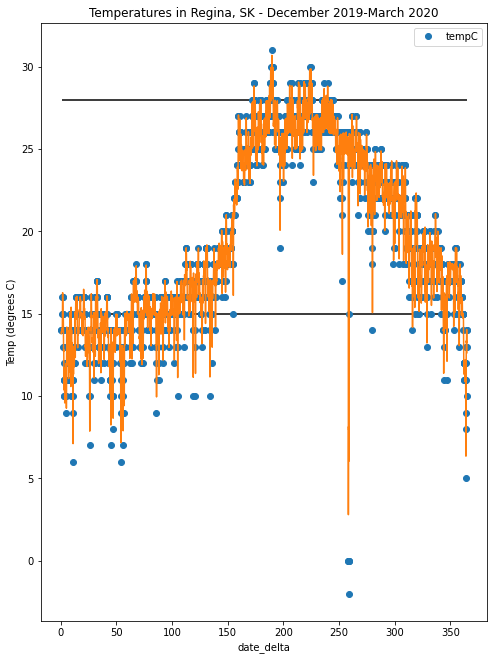

In [33]:
x = df['date_delta']

df.plot('date_delta','tempC',style='o')
plt.ylabel('Temp (degrees C)')
plt.title('Temperatures in Regina, SK - December 2019-March 2020')
plt.plot(x,yfit)
plt.hlines(28.0,1,365)
plt.hlines(15,1,365)
plt.show()

In [27]:
from sklearn.model_selection import train_test_split

# first remove the const column because unlike statsmodels, SciKit-Learn will add that in for us
X = X.drop('const', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

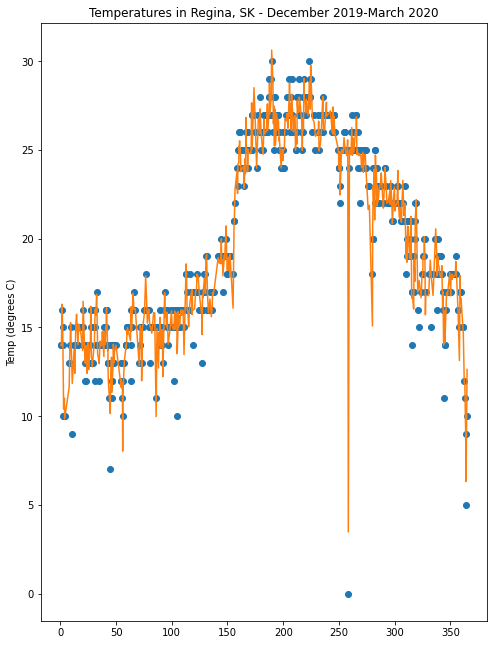

The Explained Variance: 0.98
The Mean Absolute Error: 0.58 degrees celsius
The Median Absolute Error: 0.34 degrees celsius


In [28]:
from sklearn.linear_model import LinearRegression

# instantiate the regressor class
regressor = LinearRegression()

# fit the build the model by fitting the regressor to the training data
regressor.fit(X_train, y_train)

# make a prediction set using the test set
prediction = regressor.predict(X_test)

#print (X_test)
#print (y_test)

x = X_test['date_delta']

df_final = pd.DataFrame({'x':x, 'yData':y_test, 'yFit': prediction, 'Residual': y_test-prediction})
df_final = df_final.sort_values(by=['x'])

plt.plot(df_final['x'],df_final['yData'],'o')
plt.ylabel('Temp (degrees C)')
plt.title('Temperatures Malta - 2019')
plt.plot(df_final['x'],df_final['yFit'])
plt.show()

# Evaluate the prediction accuracy of the model
from sklearn.metrics import mean_absolute_error, median_absolute_error
print("The Explained Variance: %.2f" % regressor.score(X_test, y_test))
print("The Mean Absolute Error: %.2f degrees celsius" % mean_absolute_error(y_test, prediction))
print("The Median Absolute Error: %.2f degrees celsius" % median_absolute_error(y_test, prediction))
